# Machine learning project for studying dataset pCT-Proton-3-ALPIDE-Chips.
## Using the K-Neighbors model for clustering tracks on having signs of anomalies and without them
### Alpatov Andrej

## Import of required packages

In [106]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import features.dataframe_info as dfi
import features.grouping_dataframe as gdf
import features.add_column_with_count_of_elements as coe
import features.create_x_y_train_and_test_sets
import features.fine_tuning_of_kneighbors_model as ft
import visualization.plot_generator as pg
from data import data_reader_from_csv as dr
import models.k_neighbors_model as knm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

## Loading a dataset pCT-Proton-3-ALPIDE-Chips as a pandas dataframe

In [75]:
df = dr.read_data_set('pctdata.csv')
df

,id_plane,id_x,id_y,i_event,i_time_stamp
0,1,492.0,310.0,32,21600
1,1,493.0,310.0,32,21600
2,1,493.0,311.0,32,21600
3,1,492.0,311.0,32,21600
4,1,493.0,312.0,32,21600
...,...,...,...,...,...
220133,0,472.0,271.0,240306,19215829070
220134,0,472.0,272.0,240306,19215829070
220135,0,473.0,272.0,240306,19215829070
220136,0,472.0,273.0,240306,19215829070


## Basic information about the dataset

In [76]:
dfi.dataframe_all_basic_information(df)#dataframe_info.dataframe_all_basic_information(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220138 entries, 0 to 220137
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_plane      220138 non-null  int64  
 1   id_x          220138 non-null  float64
 2   id_y          220138 non-null  float64
 3   i_event       220138 non-null  int64  
 4   i_time_stamp  220138 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 8.4 MB


(None,
             id_plane           id_x           id_y        i_event  \
 count  220138.000000  220138.000000  220138.000000  220138.000000   
 mean        0.977087     542.052535     293.056724  121902.603517   
 std         0.808873     164.238880      95.414469   68927.426627   
 min         0.000000       0.000000       0.000000      32.000000   
 25%         0.000000     498.000000     253.000000   62468.000000   
 50%         1.000000     540.000000     293.000000  125313.000000   
 75%         2.000000     587.000000     340.000000  179091.000000   
 max         2.000000    1023.000000     511.000000  240306.000000   
 
        i_time_stamp  
 count  2.201380e+05  
 mean   9.747214e+09  
 std    5.513849e+09  
 min    2.160000e+04  
 25%    4.991985e+09  
 50%    1.002388e+10  
 75%    1.431988e+10  
 max    1.921583e+10  ,
 (220138, 5))

## Number of unique Labels in the columns: 'id_plane', 'i_event', 'i_time_stamp'

In [77]:
LABELS=['id_plane', 'i_event', 'i_time_stamp']
dfi.number_unique_labels_in_dataframe_columns(df, LABELS)

id_plane            3
i_event         22789
i_time_stamp    22789
dtype: int64

#### Grouping dataframe by i_event and id_plane values. Average and standard deviation are calculated for id_x and id_y values

In [78]:
df_grouped_by_i_event_and_id_plane = \
    gdf.grouping_dataframe_(df, ['i_event', 'id_plane'], ['id_x', 'id_y'], [np.mean, np.std])

    # Simplification of the structure, removed the hierarchy in the column names
df_temp = pd.DataFrame()
df_temp['i_event']= df_grouped_by_i_event_and_id_plane['i_event']
df_temp['id_plane'] = df_grouped_by_i_event_and_id_plane['id_plane']
df_temp['id_x_std'] = df_grouped_by_i_event_and_id_plane[('id_x', 'std')]
df_temp['id_x_mean'] = df_grouped_by_i_event_and_id_plane[('id_x', 'mean')]
df_temp['id_y_std'] = df_grouped_by_i_event_and_id_plane[('id_y', 'std')]
df_temp['id_y_mean'] = df_grouped_by_i_event_and_id_plane[('id_y', 'mean')]

#### Adding columns with the standard deviation of the coordinate values and the frequency of occurrence of i_event values to the dataframe

In [79]:
# add columns 'std_x' and 'std_y' to dataframe: df_plus_std_and_mean
df_plus_std_and_mean =df.merge(df_temp, on=['i_event', 'id_plane'])

# Counting the frequency of values in the i_event column and adding the result to the dataframe
df_with_std_and_eventCount = coe.add_column_with_count_of_elements(df_plus_std_and_mean,
                                                                   'i_event', 'event_count')

## Dataframe with 'new' columns:
### 'id_x_std',  'id_x_mean',  'id_y_std',  'id_y_mean',  'event_count'

In [80]:
df_with_std_and_eventCount

,id_plane,id_x,id_y,i_event,i_time_stamp,id_x_std,id_x_mean,id_y_std,id_y_mean,event_count
0,1,492.0,310.0,32,21600,1.264911,494.000000,1.264911,312.000000,16
1,1,493.0,310.0,32,21600,1.264911,494.000000,1.264911,312.000000,16
2,1,493.0,311.0,32,21600,1.264911,494.000000,1.264911,312.000000,16
3,1,492.0,311.0,32,21600,1.264911,494.000000,1.264911,312.000000,16
4,1,493.0,312.0,32,21600,1.264911,494.000000,1.264911,312.000000,16
...,...,...,...,...,...,...,...,...,...,...
220133,0,472.0,271.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11
220134,0,472.0,272.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11
220135,0,473.0,272.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11
220136,0,472.0,273.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11


## Adding a feature 'anomaly'
#### Dataframe without anomalies (i_event contains one group of items (about 10 tracks), where the standard deviation is less than 1.2)

In [81]:
# Getting a part of a dataframe, filtered by the values of the i_event and id_plane columns
df_without_anomaly = df_grouped_by_i_event_and_id_plane[(df_grouped_by_i_event_and_id_plane[('id_x', 'std')] < 1.2) &
                                                        (df_grouped_by_i_event_and_id_plane[('id_y', 'std')] < 1.2)]

df_temp = df_without_anomaly[['i_event', 'id_plane']]
# merge the dataframe df_with_std_and_eventCount (inner join) to get the part
# that has the corresponding values in the 'i_event' and 'id_plane' columns
df_part_without_anomaly =df_with_std_and_eventCount.merge(df_temp, on=['i_event', 'id_plane'])
# Populating a column with 1 (no anomalies)
df_part_without_anomaly['anomaly']=1

df_part_without_anomaly

C:\Users\andre\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\andre\anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,id_plane,id_x,id_y,i_event,i_time_stamp,id_x_std,id_x_mean,id_y_std,id_y_mean,event_count,anomaly
0,2,558.0,422.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
1,2,559.0,422.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
2,2,559.0,423.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
3,2,558.0,423.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
4,2,558.0,424.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
...,...,...,...,...,...,...,...,...,...,...,...
181574,0,472.0,271.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1
181575,0,472.0,272.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1
181576,0,473.0,272.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1
181577,0,472.0,273.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1


#### Dataframe with anomalies (i_event contains more than one group of items or one large group (about 20 tracks), where the standard deviation is greater than 2.2)


In [82]:
# Getting a part of a dataframe, filtered by the values of the i_event and id_plane columns
df_with_anomaly = df_grouped_by_i_event_and_id_plane[(df_grouped_by_i_event_and_id_plane[('id_x', 'std')] > 2.2) |
                                                     (df_grouped_by_i_event_and_id_plane[('id_y', 'std')] > 2.2)]

df_temp = df_with_anomaly[['i_event', 'id_plane']]
# merge the dataframe df_with_std_and_eventCount (inner join) to get the part
# that has the corresponding values in the 'i_event' and 'id_plane' columns
df_part_with_anomaly =df_with_std_and_eventCount.merge(df_temp, on=['i_event', 'id_plane'])
# Populating a column with 1 (no anomalies)
df_part_with_anomaly['anomaly']=0

df_part_with_anomaly

C:\Users\andre\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\andre\anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,id_plane,id_x,id_y,i_event,i_time_stamp,id_x_std,id_x_mean,id_y_std,id_y_mean,event_count,anomaly
0,0,291.0,88.0,440,32026798,116.322999,474.040000,140.308018,309.440000,25,0
1,0,291.0,89.0,440,32026798,116.322999,474.040000,140.308018,309.440000,25,0
2,0,290.0,89.0,440,32026798,116.322999,474.040000,140.308018,309.440000,25,0
3,0,291.0,90.0,440,32026798,116.322999,474.040000,140.308018,309.440000,25,0
4,0,292.0,88.0,440,32026798,116.322999,474.040000,140.308018,309.440000,25,0
...,...,...,...,...,...,...,...,...,...,...,...
18410,2,609.0,332.0,240222,19215761872,18.316497,588.304348,24.898847,303.956522,23,0
18411,2,609.0,333.0,240222,19215761872,18.316497,588.304348,24.898847,303.956522,23,0
18412,2,608.0,333.0,240222,19215761872,18.316497,588.304348,24.898847,303.956522,23,0
18413,2,610.0,331.0,240222,19215761872,18.316497,588.304348,24.898847,303.956522,23,0


## United dataframe containing observation with and without anomalies sorted by 'i_event
#### The part of the original dataframe (about 9%) with standard deviation values in the range from 1.2 to 2.2 is not included due to the complexity of the manual clustering.
##### When building a model, the standard deviation will not be taken into account, so this will not affect the accuracy of the model in any way.

In [83]:
# Create dataframe containing observation with and without anomalies
df_all_entries = df_part_without_anomaly.append(df_part_with_anomaly)
# Sorted by 'i_event
df_all_entries_sorted_by_i_event = df_all_entries.sort_values('i_event')

df_all_entries_sorted_by_i_event

,id_plane,id_x,id_y,i_event,i_time_stamp,id_x_std,id_x_mean,id_y_std,id_y_mean,event_count,anomaly
0,2,558.0,422.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
1,2,559.0,422.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
2,2,559.0,423.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
3,2,558.0,423.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
4,2,558.0,424.0,47,33598,0.831209,558.909091,1.120065,423.363636,11,1
...,...,...,...,...,...,...,...,...,...,...,...
181575,0,472.0,272.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1
181576,0,473.0,272.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1
181577,0,472.0,273.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1
181578,0,474.0,271.0,240306,19215829070,0.981650,472.181818,0.981650,271.181818,11,1


## Create Predictor and  target variables.
#### Target column: 'anomaly'
#### Predictor columns: 'id_plane', 'id_x', 'id_y', 'event_count'
## Create train and test sets:

In [84]:
# Create predictor and  target variables, : X, y
# Create train and test sets: X_train, X_test, y_train, y_test

y, X, X_train, X_test, y_train, y_test = features.create_x_y_train_and_test_sets.create_x_y_train_and_test_sets(
    df_all_entries_sorted_by_i_event, 'anomaly', ['id_plane', 'id_x', 'id_y', 'event_count'],
     0.2, 42)

print('\nPredictor variables:\n', X, '\n\nTarget variable:\n', y)


Predictor variables:
 [[  2. 558. 422.  11.]
 [  2. 559. 422.  11.]
 [  2. 559. 423.  11.]
 ...
 [  0. 472. 273.  11.]
 [  0. 474. 271.  11.]
 [  0. 471. 272.  11.]] 

Target variable:
 [1 1 1 ... 1 1 1]


# Model: KNeighborsClassifier
### with n_neighbors=1 and scaling the data

In [85]:
# Instantiate and fit a Pipeline with k-NN classifier to the scaled data
knn_scaled = knm.k_neighbors_model(2, X_train,y_train).fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier(n_neighbors = 2).fit(X_train, y_train)

# Compute and print metrics. Comparison of model accuracy with scaled and not scaled data
print(('\nShape of Array with Data: {}'.format(X.shape)))
print('\nAccuracy without Scaling: {}'.format(knn_unscaled.score(X_test, y_test)))
print('\nAccuracy with Scaling: {}'.format(knn_scaled.score(X_test, y_test)))


Shape of Array with Data: (199994, 4)

Accuracy without Scaling: 0.9897497437435936

Accuracy with Scaling: 0.9940498512462812


## Fine-tuning of model
### Calculating model accuracy for neighbors values from 1 to 9

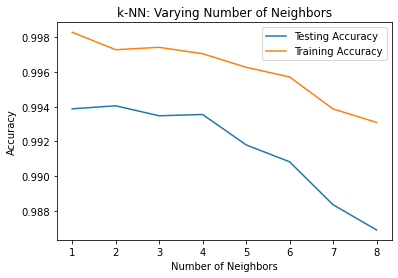

In [86]:
# Calculation of the train_accuracy and  test_accuracy of the k-neighbors model
# with the values of Parameter n_neighbors from the array 'neighbors'
neighbors, train_accuracy, test_accuracy = \
    ft.fine_tuning_of_kneighbors_model(X_train, y_train, X_test, y_test)

# Generate plot
pg.plot_generator(['k-NN: Varying Number of Neighbors', 'Number of Neighbors', 'Accuracy'],
                  [(neighbors, test_accuracy, 'Testing Accuracy'),
                   (neighbors, train_accuracy, 'Training Accuracy')])

## Confusion matrix, classification report and number of errors

In [87]:
# Predict the labels of the test data: y_pred
y_pred = knn_scaled.predict(X_test)

# Compute and print the confusion matrix and classification report

print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# The recall is intuitively the ability of the classifier to find all the positive samples.

# Print the number of errors
num_err = np.sum(y != knn_scaled.predict(X))
print("Number of errors:", num_err)


Confusion matrix:
 [[ 3595    88]
 [  150 36166]]

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      3683
           1       1.00      1.00      1.00     36316

    accuracy                           0.99     39999
   macro avg       0.98      0.99      0.98     39999
weighted avg       0.99      0.99      0.99     39999

Number of errors: 673


In [88]:
# Create a dataframe for further models
df_to_make_models =  df_all_entries_sorted_by_i_event[['id_plane', 'id_x', 'id_y', 'event_count']]
labels_for_model = df_all_entries_sorted_by_i_event['anomaly']

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

c_space= np.logspace(-5, 1, num=15)
penalty_space=['l1', 'l2', 'elasticnet', 'none']
X=df_to_make_models
y=labels_for_model


'''
params={'C':c_space, 'penalty':penalty_space}
logreg=LogisticRegression()

searcher = GridSearchCV(logreg, params, cv=5)
searcher.fit(X, y)

print('Best Logreg params: ', searcher.best_params_)
print('Best score of Logistic Regression:', searcher.best_score_)

##########################################################
Best Logreg params:  {'C': 1e-05, 'penalty': 'l2'}
Best score of Logistic Regression: 0.9185825851706596
##########################################################
'''

logreg =LogisticRegression(C=0.00001)
cv_scores=cross_val_score(logreg, X, y, cv=5)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.9185825851706596


In [90]:
from sklearn.svm import LinearSVC
'''
c_space=np.logspace(-5, 3, num=15)
penalty_space=['l1', 'l2']
loss_space=['hinge', 'squared_hinge']
params={'C':c_space, 'penalty':penalty_space, 'loss':loss_space}

lsvm=LinearSVC()
searcher=GridSearchCV(lsvm, params, cv=5)
searcher.fit(X, y)

print('Best LinearSVC params: ', searcher.best_params_)
print('Best score of LinearSVC:', searcher.best_score_)

###############################################################
Best LinearSVC params:  {'C': 0.0005179474679231213, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best score of LinearSVC: 0.9180625652948189
###############################################################
'''
lsvm = LinearSVC(C=0.0005)
lsvm.fit(X_train, y_train)
y_pred = lsvm.predict(X_test)

model_score = lsvm.score(X_test, y_test)
print('Best score of LinearSVC:', model_score)

Best score of LinearSVC: 0.917847946198655


C:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [91]:
from  sklearn.svm import  SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

svm=SVC()

#c_space=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#kernel_space=['linear', 'rbf']
#params={'kernel':kernel_space}

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
acc_score_svc=accuracy_score(y_test,y_pred)
print('SVC accuracy_score: ', acc_score_svc)

SVC accuracy_score:  0.9104477611940298


In [92]:
from sklearn.tree import DecisionTreeClassifier

criterion_space=['gini','entropy']
splitter_space=['best', 'random']
max_depth_space=[2,5,10,20, None]
min_samles_leaf_space=[0.12, 0.14, 0.16, 0.18, 0.1, 1]

params ={'criterion': criterion_space, 'splitter': splitter_space,
         'max_depth':max_depth_space, 'min_samples_leaf': min_samles_leaf_space}
dt =DecisionTreeClassifier()
searcher = GridSearchCV(dt, params, cv=5, n_jobs=-1)

searcher.fit(X_train, y_train)

dt=searcher.best_estimator_
print('Decision tree score: ', searcher.best_score_)
print('Decision tree best params: ', searcher.best_params_)

Decision tree score:  0.9901059408106503
Decision tree best params:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'splitter': 'random'}


In [93]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import  accuracy_score
from sklearn.naive_bayes import GaussianNB

# Instantiate knn
knn = KNeighborsClassifier(n_neighbors=2)

clf3 = GaussianNB()

classifiers = [('K Nearest Neighbours', knn), ('Classification Tree', dt), ('svc', svm)]

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers, n_jobs=3)

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.5f}'.format(accuracy))

Voting Classifier: 0.99230


In [94]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(base_estimator=dt, n_estimators=1000, n_jobs=-1, random_state=1,
                       oob_score=True)

bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
aac_oob =bc.oob_score_
print('Bugging Classifier oob_score: {:.5f}'.format(aac_oob))

Bugging Classifier oob_score: 0.99457


In [95]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=300,random_state=2)

rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Randomforest accuracy: {:.5f}'.format(accuracy))

Randomforest accuracy: 0.99350


In [96]:
from sklearn.ensemble import AdaBoostClassifier

ab =AdaBoostClassifier(base_estimator=dt, n_estimators=500, random_state=1)

ab.fit(X_train, y_train)
y_pred=ab.predict(X_test)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ab.predict_proba(X_test)[:,1]

# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

accuracy = accuracy_score(y_test, y_pred)

# Print roc_auc_score and AdaBoosting accuracy
print('AdaBoosting ROC AUC score: {:.5f}'.format(ada_roc_auc))
print('AdaBoosting accuracy: {:.5f}'.format(accuracy))

AdaBoosting ROC AUC score: 0.99583
AdaBoosting accuracy: 0.99322


In [97]:
from sklearn.ensemble import GradientBoostingClassifier

gb =GradientBoostingClassifier(n_estimators=500, random_state=1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
acs =accuracy_score(y_test, y_pred)
print('GradientBoostingClassifier accuracy: {:.5f}'.format(acs))

GradientBoostingClassifier accuracy: 0.93882


In [98]:
sgb=GradientBoostingClassifier(n_estimators=10, random_state=1, subsample=0.8,
                              max_features=0.2)

sgb.fit(X_train, y_train)
sgb.predict(X_test)

acc_score_sgb=accuracy_score(y_test, y_pred)
print('Accuracy stochastic gradient boosting: {:.5f}'.format(acc_score_sgb))

Accuracy stochastic gradient boosting: 0.93882


In [99]:
from xgboost import XGBClassifier

xgb_cl=XGBClassifier(n_estimators=2000, random_state=123, n_jobs=-1)
xgb_cl.fit(X_train, y_train)
y_pred=xgb_cl.predict(X_test)

acc_score_xgb=accuracy_score(y_test,y_pred)

print('XGB score: {:.5f}'.format(acc_score_xgb))

[23:58:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\andre\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGB score: 0.99227


In [100]:
import xgboost as xgb

dmatrix =xgb.DMatrix(data=X, label=y)

params={'max_depth':5}

cv_results=xgb.cv(params=params, dtrain=dmatrix,num_boost_round=500,nfold=5,
                  metrics='error',as_pandas=True,seed=123)

print('XGB cross validation mean accuracy' , ((1-cv_results["test-error-mean"]).iloc[-1]))

XGB cross validation mean accuracy 0.971614


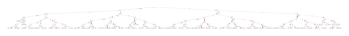

In [108]:
xgb.plot_tree(xgb_cl, num_trees=0, )
plt.show()

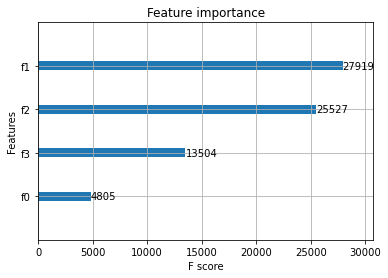

In [109]:
xgb.plot_importance(xgb_cl)
plt.show()